# Filtering barotropic tide 

This notebook aims at filetring High Frequency SSH and removing barotropic tide (large scale signal). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
import scipy.fftpack as fp
from scipy.interpolate import RegularGridInterpolator, griddata
from math import *
from dask import delayed,compute
from joblib import Parallel
from joblib import delayed as jb_delayed

# Input Parameters 

Initial and final dates : 

In [2]:
init_date = np.datetime64("2012-05-01")
final_date = np.datetime64("2012-06-01")

Paths to files : 

In [3]:
path_to_mask = "/bettik/bellemva/MITgcm/mask/mask_MITgcm_nobay.npy" # in numpy .npy format
path_to_input = "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_" # including the file name prefix 
path_to_save = "/bettik/bellemva/MITgcm/MITgcm_bar/MITgcm_bar_" # including the file name prefix 

# Functions 

In [4]:
def create_cartesian_grid (latitude,longitude,dx):
    """ 
    Creates a cartesian grid (regular in distance, kilometers) from a geodesic latitude, longitude grid. 
    The new grid is expressed in latitude, longitude coordinates.

    Parameters
    ----------
    longitude : numpy ndarray 
        Vector of longitude for geodesic input grid. 
    latitude : numpy ndarray 
        Vector of latitude for geodesic input grid. 
    dx : float 
        Grid spacing in kilometers. 

    Returns
    -------
    ENSLAT2D : 
        2-D numpy ndarray of the latitudes of the points of the cartesian grid 
    ENSLON2D : 
        2-D numpy ndarray of the longitudes of the points of the cartesian grid 
    """
    km2deg = 1/111

    # ENSEMBLE OF LATITUDES # 
    ENSLAT = np.arange(latitude[0],latitude[-1]+dx*km2deg,dx*km2deg)
    range_lon = longitude[-1]-longitude[0]

    if longitude.size%2 == 0 : 
        nstep_lon = floor(range_lon/(dx*km2deg))+2
    else : 
        nstep_lon = ceil(range_lon/(dx*km2deg))+2
    ENSLAT2D = np.repeat(np.expand_dims(ENSLAT,axis=1),axis=1,repeats=nstep_lon)

    # ENSEMBLE OF LATITUDES # 
    mid_lon = (longitude[-1]+longitude[0])/2
    ENSLON2D=np.zeros_like(ENSLAT2D)

    for i in range(len(ENSLAT)):
        d_lon = dx*km2deg*(np.cos(np.pi*latitude[0]/180)/np.cos(np.pi*latitude[i]/180))
        d_lon_range = np.array([i*d_lon for i in range (1,int(nstep_lon/2)+1)])
        lon_left = np.flip(mid_lon-d_lon_range)
        lon_right = mid_lon+d_lon_range
        ENSLON2D[i,:]=np.concatenate((lon_left,lon_right))

    return ENSLAT2D, ENSLON2D, ENSLAT2D.shape[0], ENSLAT2D.shape[1]
    

In [5]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [10]:
def highpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]>1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [11]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [12]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [13]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [14]:
def extract_bar_tide(ssh0,dx):

    nx = ssh0.shape[1]
    ny = ssh0.shape[0]

    kx = np.fft.fftfreq(3*nx,dx) # km
    ky = np.fft.fftfreq(3*ny,dx) # km
    k, l = np.meshgrid(kx,ky)
    wavenum2D = np.sqrt(k**2 + l**2)

    lambda_bar = 400
    lowpass_bar = lowpass(lambda_bar,nx,ny,wavenum2D)
    highpass_bar = highpass(lambda_bar,nx,ny,wavenum2D)

    window = create_spatial_window(nx,ny)

    ssh = extend(ssh0,nx,ny)
    ssh = ssh * window
    ssh_freq = fp.fft2(ssh)
    # ssh_freq_filtered = lowpass_bar * ssh_freq
    ssh_freq_filtered = highpass_bar * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny,nx:2*nx]

    return ssh_filtered


In [15]:
def create_bar_tide(date):

    ds = xr.open_dataset(path_to_input+date.astype('str').replace('-','')+".nc")
    mask = np.load(path_to_mask)

    # PROCESSING #

    ssh_hf = ds.ssh_hf.where(mask==False,np.nan)

    ssh_hf = ssh_hf.coarsen(longitude=4,latitude=4,boundary='trim').mean()
    ssh_hf = ssh_hf.load().chunk({'time':1})

    x_axis = Axis(ssh_hf.longitude.values,is_circle=True)
    y_axis = Axis(ssh_hf.latitude.values,is_circle=True)
    t_axis = TemporalAxis(ssh_hf.time.values)

    grid = Grid3D(y_axis, x_axis, t_axis, ssh_hf.values.transpose(1,2,0))
    has_converged, filled = fill.gauss_seidel(grid,num_threads=16)

    ssh_hf_filled = ssh_hf.copy(deep=True,data=filled.transpose(2,0,1)).chunk({'time':1})


    # TO CARTESIAN GRID #

    dx = 10 # in kilometers, spacing of the grid 

    ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.latitude.values,
                                                            ssh_hf_filled.longitude.values,
                                                            dx)

    array_cart_ssh = ssh_hf_filled.interp(latitude=('z',ENSLAT2D.flatten()),
                                        longitude=('z',ENSLON2D.flatten()),
                                        ).values

    # INTERPOLATION OF NaNs # 
    x_axis = Axis(np.arange(i_lon))
    y_axis = Axis(np.arange(i_lat))
    t_axis = TemporalAxis(ssh_hf.time.values)

    grid = Grid3D(y_axis, x_axis, t_axis, array_cart_ssh.reshape((24,i_lat,i_lon)).transpose(1,2,0))
    has_converged, filled = fill.gauss_seidel(grid,num_threads=16)

    mask_cart = np.isnan(array_cart_ssh[0].reshape((i_lat,i_lon)))

    cart_ssh_hf = xr.DataArray(data=filled.transpose(2,0,1),
                            dims=["time","y","x"],
                            coords = dict(
                                time = ssh_hf_filled.time.values,
                                y=(["y"],np.arange(i_lat)),
                                x=(["x"],np.arange(i_lon))
                            )).chunk({'time':1})
    
    
    # EXTRACTING BAROTROPIC TIDE # 
    cart_ssh_filtered = np.array(Parallel(n_jobs=16,backend='multiprocessing')(jb_delayed(extract_bar_tide)(cart_ssh_hf[i].values,dx) for i in range(24)))

    lon2d, lat2d = np.meshgrid(ssh_hf.longitude.values, ssh_hf.latitude.values)

    geo_filtered = np.array(Parallel(n_jobs=16,backend='multiprocessing')(jb_delayed(griddata)(np.array([ENSLAT2D.flatten(),ENSLON2D.flatten()]).T,
                                        cart_ssh_filtered[i].flatten(),
                                        (lat2d,lon2d),'cubic') for i in range(24)))
    

    # FINAL FILE CREATION # 

    ssh_filtered = ssh_hf.copy(deep=True,data=geo_filtered).chunk({'time':1})
    
    ssh_filtered = ssh_filtered.interp_like(ds,kwargs={"fill_value": "extrapolate"}) #interpolation 

    ssh_filtered = ssh_filtered.where(mask==False,np.nan)

    ssh_filtered = ssh_filtered.rename("ssh_bar")

    return ssh_filtered
    #ssh_filtered.to_netcdf(path_to_save+date.astype('str').replace('-','')+".nc")


# Call to functions 

In [ ]:
array_date = np.arange(init_date,final_date,np.timedelta64(1,'D'))

for date in array_date:
    create_bar_tide(date)
    print(date," : done")

### Test 

In [17]:
array_date = np.arange(init_date,final_date,np.timedelta64(1,'D'))

igw_test = create_bar_tide(array_date[20])

/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [20]:
array_date[20]

numpy.datetime64('2012-05-21')

In [25]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+array_date[20].astype("str").replace("-","")+".nc")

ssh_bar = ds.ssh_bar.load()
ssh_hf = ds.ssh_hf.load()


In [ ]:
plt.hist(ssh_hf[0,:,:].values.flatten())

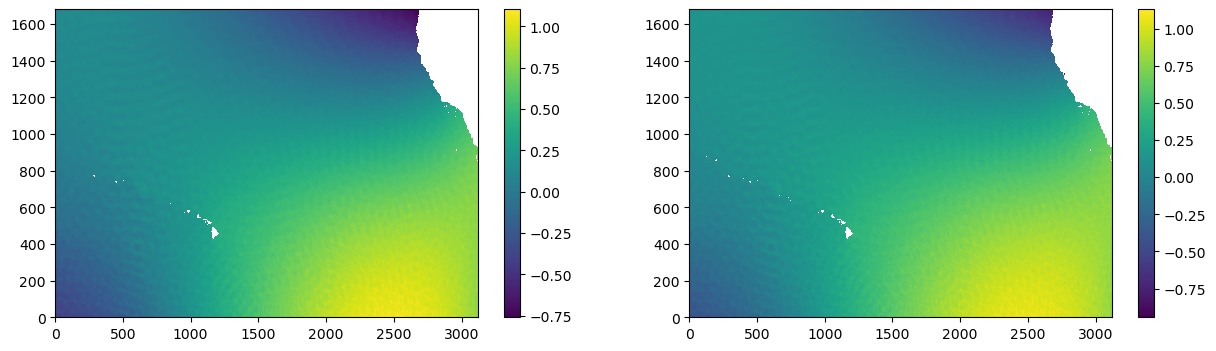

In [26]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(15,4))
plot0 = ax[0].pcolormesh(ssh_bar[0,:,:]+igw_test[0,:,:])
fig.colorbar(ax=ax[0],mappable=plot0)

plot1 = ax[1].pcolormesh(ssh_hf[0,:,:])
fig.colorbar(ax=ax[1],mappable=plot1)


# Reorganizing the result files 

This command is adding the files saved in *path_to_save* into the existing files of *path_to_general_files*. 

In [4]:
path_to_general_files = "/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"

In [5]:
dates = np.arange(init_date,final_date)

# deleting the content of file.sh 
file = open("./nco_bash.sh","w")
file.close()

for d in dates:

    command = "ncks -h -A "

    command += path_to_save+d.astype('str').replace("-","")+".nc "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc \n"
    
    file = open("./nco_bash.sh","a")
    
    file.write(command)

    file.close()

In [ ]:
!source /applis/site/nix.sh
!chmod +x ./nco_bash.sh
!./nco_bash.sh

# Creating the *ssh_cor* and *ssh_igw* variables 

In [7]:
dates = np.arange(init_date,final_date)

# deleting the content of file.sh 
file = open("./nco_bash.sh","w")
file.close()

for d in dates:

    command = "ncap2 -h -A -s \"ssh_cor=ssh_dedac-ssh_bar\" "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc \n"

    command += "ncap2 -h -A -s \"ssh_igw=ssh_hf-ssh_bar\" "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc \n"
    
    file = open("./nco_bash.sh","a")
    
    file.write(command)

    file.close()


In [ ]:
!source /applis/site/nix.sh
!chmod +x ./nco_bash.sh
!./nco_bash.sh

In [ ]:
dates = np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-07-01"))

# deleting the content of file.sh 
file = open("./nco_bash.sh","w")
file.close()


for d in dates:

    command = "ncks -h -C -O -x -v ssh_it "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc "

    command += path_to_general_files+d.astype('str').replace("-","")+".nc \n"
    
    file = open("./nco_bash.sh","a")
    
    file.write(command)

    file.close()